# Bayesian Lasso regression

Last section we developed the theory for Bayesian regression. Here we *extend* the model using another regularizing prior using the Laplace distribution. Since the posterior has no analytical form, we need to approximate it, for instance using sampling. I'' demonstrate the Bayesian Lasso using `rstan` and `greta`.

**As usual I do not take warranty for the correctness or completeness of this document.**

In [25]:
options(repr.plot.width=12, repr.plot.height=4)

In [26]:
suppressMessages(library(ggplot2))
suppressMessages(library(cowplot))
suppressMessages(library(rstan))
suppressMessages(library(greta))
suppressMessages(library(DiagrammeR))
theme_set(theme_cowplot())

source("_util/util.R")

In [27]:
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())

In classical LASSO regression we put an $\ell_1$ penalty on the coefficients of the linear model, such that we try to optimize the following objective:

\begin{align}
\arg\min_{\theta} - \mathcal{L}(\boldsymbol \beta) + || \boldsymbol \beta ||_1,
\end{align}

where $\mathcal{L}(\boldsymbol \beta)$ is the likelihood and $\boldsymbol \beta$ the model parameters. In a fully Bayesian setting this can be interpreted as conditional independent Laplace priors on the components of $\boldsymbol \beta$:

\begin{align}
p(\boldsymbol \beta \mid \sigma^2) =\prod_i^p \frac{\lambda}{2\sqrt{\sigma^2}} \exp \left( -\lambda \frac{|\beta_i|}{\sqrt{\sigma^2}}  \right)
\end{align}

Our model will then have the following hierarchical form (where we use the compound normal-exponential distribution (see the `Stan` reference) instead of the Laplace distribution):

\begin{align}
 \boldsymbol \beta \mid \sigma^2,\tau_1^2, \dots, \tau_p^2 &\sim \mathcal{N}(\mathbf{0}, \sigma^2 \mathbf{D}_{\tau}),\\
 \mathbf{D}_{\tau} &= \text{diag}(\tau_1^2, \dots, \tau_p^2),\\
 \tau_1^2, \dots, \tau_p^2 & \sim \prod_1^p \text{Exponential}\left(\frac{\lambda^2}{2}\right),\\
 \sigma^2 &\sim \mathcal{IG}(a, b),\\
\end{align}

where $\lambda$, $a$ and $b$ are hyperparamters. $\lambda$ essentially corresponds to the frequentist LASSO regularization parameter. In a Bayesian setting with would either use an ampirical Bayes approach, use a hyperprior, or -as we will do it here for demonstration- take an educated guess.

Now, that the prior is specified, let's infer the posterior distribution on some data. First we create some artificial data for a simple linear regression model.

In [28]:
set.seed(23)

In [29]:
n <- 1000
beta <- rnorm(1, 1)

X <- matrix(rnorm(n), n)
y <- X %*% beta + rnorm(n, 0, .1)

In [30]:
beta

[1] 1.193212

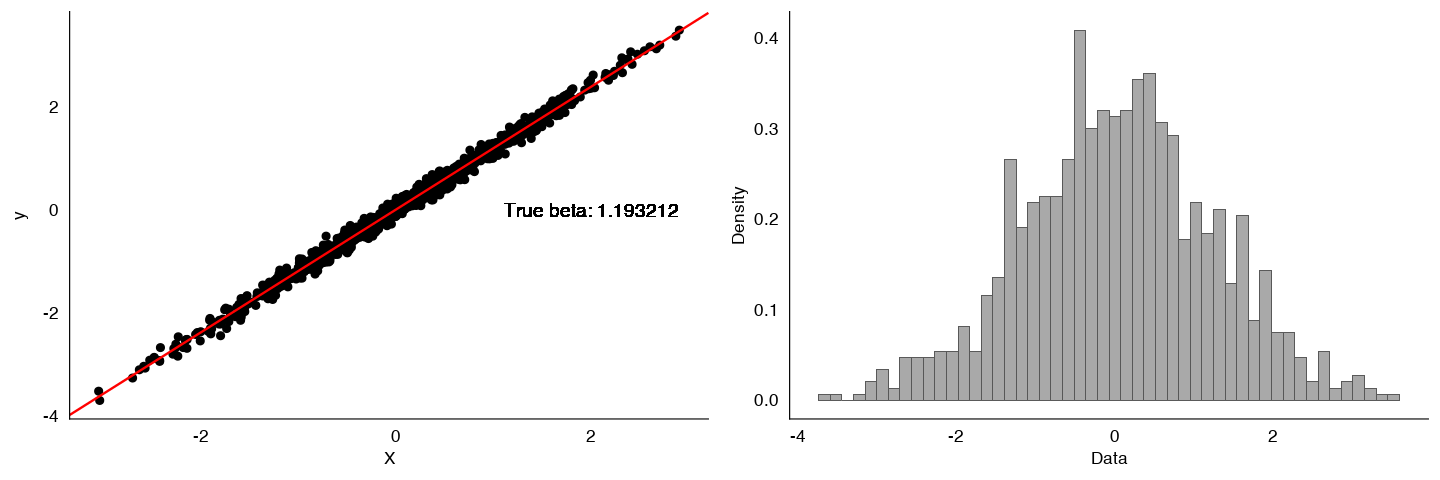

In [31]:
p1.scatter <- ggplot(data.frame(X=X, y=y)) +
  geom_point(aes(X, y)) +
  geom_abline(slope = beta, color="red") +
  geom_text(data=NULL, x = 2, y = 0, label = paste("True beta:", format(beta))) +
  simon_theme()
pl.hist <- ggplot(data.frame(Y=y)) +
  geom_histogram(aes(Y, y=..density..), fill="darkgrey", color="black", cex=.1, bins=50) +
  simon_theme() +
  scale_y_continuous("Density") +
  scale_x_continuous("Data")

cowplot::plot_grid(p1.scatter, pl.hist, ncol=2, align="vh")

### Inference using Stan

First we will use `Stan` for inference if the posterior. Stan requires to set up the model in the following form.

In [32]:
writeLines(readLines("_models/bayesian_lasso_exponential_normal.stan"))

data {
  int<lower=0> N;
  
  vector[N] x;
  vector[N] y;

  real<lower=0> lambda;
}

parameters {
  real beta;
  real sigma;
  real tau;
}

model {
  tau ~ exponential(lambda  * lambda / 2);
  sigma ~ inv_gamma(1, 1);
  beta ~ normal(0, sigma * tau);
  
  y ~ normal(beta * x, sigma);
}


Then we estimate the posterior of the parameters:

In [33]:
m_norm <- stan(
    "_models/bayesian_lasso_exponential_normal.stan",
    data = list(N = n, x = X[,1], y = y[,1], lambda = 1)
)

Warning message:
“There were 2 divergent transitions after warmup. Increasing adapt_delta above 0.8 may help. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”Warning message:
“Examine the pairs() plot to diagnose sampling problems
”

Let's see the posterior quantiles.

In [34]:
summary(m_norm)$summary

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
beta,1.194855e+00,5.404155e-05,0.003074185,1.188719e+00,1.192815e+00,1.194796e+00,1.1968812,1.2009816,3235.969,0.999443
sigma,9.972532e-02,3.515642e-05,0.002223487,9.533726e-02,9.820789e-02,9.972285e-02,0.1012095,0.1040387,4000.000,1.000307
tau,7.267700e+00,5.858691e-02,2.359239641,3.942835e+00,5.611920e+00,6.863759e+00,8.5276337,12.8199370,1621.597,1.000052
lp__,1.800631e+03,3.218629e-02,1.243921702,1.797442e+03,1.800039e+03,1.800944e+03,1801.5357442,1802.0811410,1493.634,1.001168


ci_level: 0.8 (80% intervals)
outer_level: 0.95 (95% intervals)


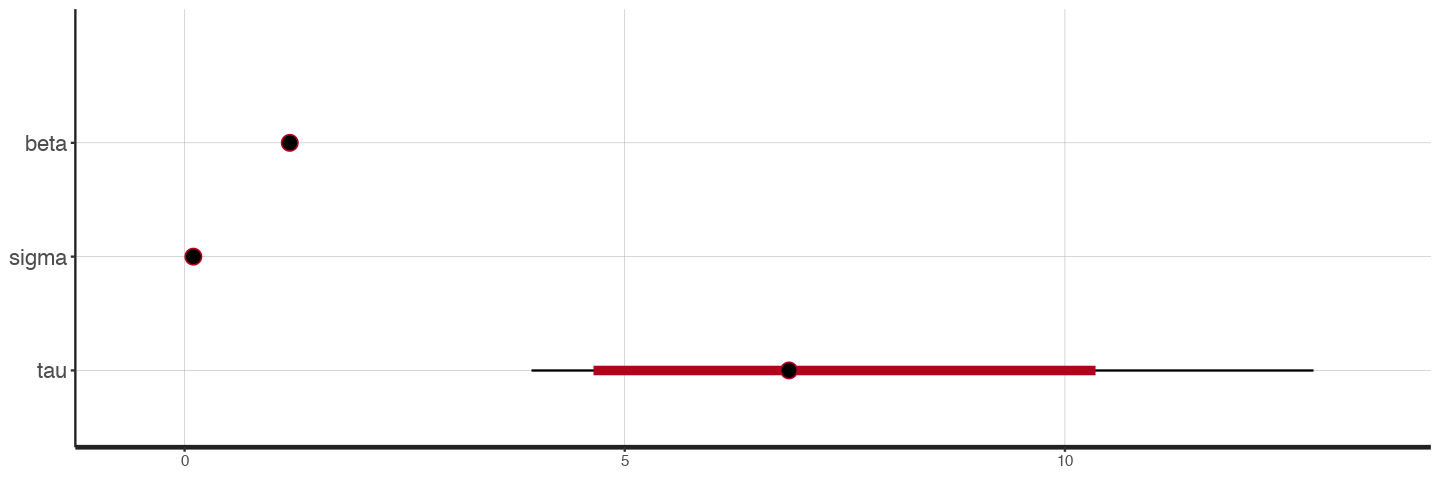

In [35]:
plot(m_norm, pars=c("beta","sigma", "tau"))

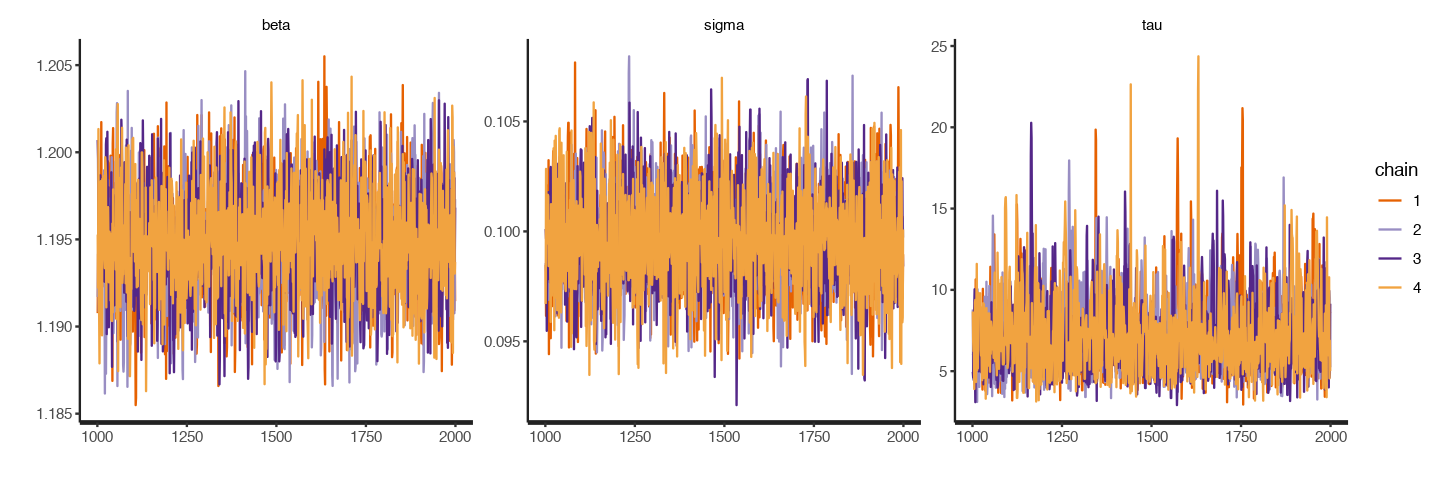

In [36]:
traceplot(m_norm)

Stan worked pretty well in infering the true values. Only the posterior interval for `tau` is fairly large. In this case, since the coefficients were easily identifiable due to the dimensionality of the dat, I guess that `tau` did not play too much of an impact on $\beta$.

Let's quickly check what would happen if we don't formulate the prior like this, but using a Laplace distribution directly. Since we used $\lambda=1$ we don't need to reparametrize.

In [37]:
writeLines(readLines("_models/bayesian_lasso_double_exponential.stan"))

data {
  int<lower=0> N;
  
  vector[N] x;
  vector[N] y;

  real<lower=0> lambda;
}

parameters {
  real beta;
  real sigma;
  real tau;
}

model {
  tau ~ exponential(lambda  * lambda / 2);
  sigma ~ inv_gamma(1, 1);
  beta ~ normal(0, sigma * tau);
  
  y ~ normal(beta * x, sigma);
}


In [38]:
m_norm_lapla <- stan(
    "_models/bayesian_lasso_double_exponential.stan",
    data = list(N = n, x = X[,1], y = y[,1], lambda = 1)
)

Warning message:
“There were 3 divergent transitions after warmup. Increasing adapt_delta above 0.8 may help. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”Warning message:
“Examine the pairs() plot to diagnose sampling problems
”

In [39]:
summary(m_norm_lapla)$summary

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
beta,1.194891e+00,5.246070e-05,0.003051331,1.189117e+00,1.192759e+00,1.194893e+00,1.1969720,1.2009248,3383.0663,0.999816
sigma,9.973071e-02,3.572837e-05,0.002259660,9.527905e-02,9.818733e-02,9.968159e-02,0.1012044,0.1042914,4000.0000,1.001115
tau,7.344901e+00,8.412067e-02,2.451659190,3.933706e+00,5.599282e+00,6.886701e+00,8.6158301,13.0877196,849.4049,1.000918
lp__,1.800600e+03,3.698801e-02,1.295519375,1.797258e+03,1.800022e+03,1.800921e+03,1801.5321985,1802.0695415,1226.7779,1.002200


In [40]:
summary(m_norm)$summary

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
beta,1.194855e+00,5.404155e-05,0.003074185,1.188719e+00,1.192815e+00,1.194796e+00,1.1968812,1.2009816,3235.969,0.999443
sigma,9.972532e-02,3.515642e-05,0.002223487,9.533726e-02,9.820789e-02,9.972285e-02,0.1012095,0.1040387,4000.000,1.000307
tau,7.267700e+00,5.858691e-02,2.359239641,3.942835e+00,5.611920e+00,6.863759e+00,8.5276337,12.8199370,1621.597,1.000052
lp__,1.800631e+03,3.218629e-02,1.243921702,1.797442e+03,1.800039e+03,1.800944e+03,1801.5357442,1802.0811410,1493.634,1.001168


Great :). Same result.

### Inference using Greta

`Greta` is another great package for Bayesian computation. Greta's model setup is more intuitive and easier to get started with, imo. We will repeat the same posterior inference using Greta. Greta uses `tensorflow` in the backend.

First we cast the data as Greta arrays and add a penalization parameter.

In [41]:
X <- as_data(X)
y <- as_data(y)
lambda <- 1

Then we set the model. As you see, we basically only need to specify the distribution of the priors.

In [42]:
sigma <- greta::inverse_gamma(1, 1)
tau   <- greta::exponential(lambda  * lambda / 2)
beta  <- greta::normal(0, sigma * tau)

After the prior is set, we set the distribution of the observed data, i.e. a Gaussian where the mean are independent variables times the coefficients.

In [43]:
mu <- X %*% beta
distribution(y) =  normal(mu, sigma)

Nest we set for which variables the posterior should be inferred: $\beta$, $\tau$ and $\sigma$.

In [44]:
mod <- model(sigma, tau, beta)

..and in the end we estimate the parameters using MCMC.

In [45]:
draws <- mcmc(mod, n_samples = 1000)

In [46]:
summary(draws)


Iterations = 1:1000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

        Mean SD Naive SE Time-series SE
sigma 0.1039  0        0              0
tau   1.1558  0        0              0
beta  1.1931  0        0              0

2. Quantiles for each variable:

        2.5%    25%    50%    75%  97.5%
sigma 0.1039 0.1039 0.1039 0.1039 0.1039
tau   1.1558 1.1558 1.1558 1.1558 1.1558
beta  1.1931 1.1931 1.1931 1.1931 1.1931


The inferred parameters are almost identical between Stan and Greta.